In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2023/Conferences.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2023/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2023/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2023/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2023/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-2023/Cities.csv
/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv
/kaggle/input/march-machine-learning-mania-2023/MTeamSpellings.csv
/k

In [2]:
start_data_season = 2003

In [3]:
m_teams_file = '/kaggle/input/march-machine-learning-mania-2023/MTeams.csv'
m_teams_df = pd.read_csv(m_teams_file)
display(m_teams_df)

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2023
1,1102,Air Force,1985,2023
2,1103,Akron,1985,2023
3,1104,Alabama,1985,2023
4,1105,Alabama A&M,2000,2023
...,...,...,...,...
372,1473,Lindenwood,2023,2023
373,1474,Queens NC,2023,2023
374,1475,Southern Indiana,2023,2023
375,1476,Stonehill,2023,2023


In [4]:
def generate_numeric_cols(df, team):
    df[f'{team}FG'] = (df[f'{team}FGM'] * 100) / df[f'{team}FGA']
    df[f'{team}FG3'] = (df[f'{team}FGM3'] * 100) / df[f'{team}FGA3']
    df[f'{team}FT'] = (df[f'{team}FTM'] * 100) / df[f'{team}FTA']

m_reg_szn_file = '/kaggle/input/march-machine-learning-mania-2023/MRegularSeasonDetailedResults.csv'
m_reg_szn_df = pd.read_csv(m_reg_szn_file)
generate_numeric_cols(m_reg_szn_df, 'W')
generate_numeric_cols(m_reg_szn_df, 'L')

display(m_reg_szn_df)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LTO,LStl,LBlk,LPF,WFG,WFG3,WFT,LFG,LFG3,LFT
0,2003,10,1104,68,1328,62,N,0,27,58,...,18,9,2,20,46.551724,21.428571,61.111111,41.509434,20.000000,72.727273
1,2003,10,1272,70,1393,63,N,0,26,62,...,12,8,6,16,41.935484,40.000000,52.631579,35.820896,25.000000,45.000000
2,2003,11,1266,73,1437,61,N,0,24,58,...,12,2,5,23,41.379310,44.444444,58.620690,30.136986,11.538462,60.869565
3,2003,11,1296,56,1457,50,N,0,18,38,...,19,4,3,23,47.368421,33.333333,54.838710,36.734694,27.272727,53.333333
4,2003,11,1400,77,1208,71,N,0,30,61,...,10,7,1,14,49.180328,42.857143,84.615385,38.709677,37.500000,62.962963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107629,2023,132,1104,82,1401,63,N,0,27,66,...,13,5,2,21,40.909091,33.333333,72.727273,29.687500,33.333333,83.333333
107630,2023,132,1272,75,1222,65,A,0,27,53,...,10,5,4,19,50.943396,50.000000,71.428571,31.250000,24.000000,67.857143
107631,2023,132,1343,74,1463,65,H,0,23,57,...,10,3,7,20,40.350877,39.130435,79.166667,44.000000,36.363636,68.421053
107632,2023,132,1345,67,1336,65,N,0,24,62,...,10,4,2,20,38.709677,21.428571,65.000000,43.137255,30.434783,93.333333


In [5]:
m_tourn_szn_file = '/kaggle/input/march-machine-learning-mania-2023/MNCAATourneyCompactResults.csv'
m_tourn_szn_df = pd.read_csv(m_tourn_szn_file)
display(m_tourn_szn_df)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2379,2022,146,1242,76,1274,50,N,0
2380,2022,146,1314,69,1389,49,N,0
2381,2022,152,1242,81,1437,65,N,0
2382,2022,152,1314,81,1181,77,N,0


In [6]:
def get_seed_number(seed):
    if 'a' in seed or 'b' in seed:
        return 17
    return int(seed[1:])

m_seed_file = '/kaggle/input/march-machine-learning-mania-2023/MNCAATourneySeeds.csv'
m_seed_df = pd.read_csv(m_seed_file)
m_seed_df['SeedNum'] = m_seed_df.Seed.apply(lambda x: get_seed_number(x))
display(m_seed_df)

,Season,Seed,TeamID,SeedNum
0,1985,W01,1207,1
1,1985,W02,1210,2
2,1985,W03,1228,3
3,1985,W04,1260,4
4,1985,W05,1374,5
...,...,...,...,...
2485,2023,Z12,1433,12
2486,2023,Z13,1233,13
2487,2023,Z14,1213,14
2488,2023,Z15,1421,15


In [7]:
def get_reg_szn_stats(season, team):
    w_games = m_reg_szn_df[m_reg_szn_df['WTeamID'] == team].rename(columns = {
        'WFG': 'FG', 'WFG3': 'FG3', 'WFT': 'FT', 'WAst': 'Ast', 'WTO': 'TO', 'WOR': 'OR', 'WDR': 'DR', 'WStl': 'Stl', 'WBlk': 'Blk', 'WPF': 'PF',
        'WScore': 'Score',
        
        'LFG': 'OppFG', 'LFG3': 'OppFG3', 'LFT': 'OppFT', 'LAst': 'OppAst', 'LTO': 'OppTO', 'LOR': 'OppOR', 'LDR': 'OppDR', 'LStl': 'OppStl', 'LBlk': 'OppBlk', 'LPF': 'OppPF',
        'LScore': 'OppScore',
        })
    w_games['Won'] = 1
    
    l_games = m_reg_szn_df[m_reg_szn_df['LTeamID'] == team].rename(columns = {
        'LFG': 'FG', 'LFG3': 'FG3', 'LFT': 'FT', 'LAst': 'Ast', 'LTO': 'TO', 'LOR': 'OR', 'LDR': 'DR', 'LStl': 'Stl', 'LBlk': 'Blk', 'LPF': 'PF',
        'LScore': 'Score',
        
        'WFG': 'OppFG', 'WFG3': 'OppFG3', 'WFT': 'OppFT', 'WAst': 'OppAst', 'WTO': 'OppTO', 'WOR': 'OppOR', 'WDR': 'OppDR', 'WStl': 'OppStl', 'WBlk': 'OppBlk', 'WPF': 'OppPF',
        'WScore': 'OppScore',
        })
    l_games['Won'] = 0
    
    games = pd.concat([w_games, l_games], axis=0, ignore_index=True)
    
    reg_szn_pct = (len(w_games) * 100) / len(games)
    
    return [   
               reg_szn_pct, 
               games['Score'].mean(), games['OppScore'].mean(), games['FG'].mean(), games['FG3'].mean(), games['FT'].mean(), games['Ast'].mean(), games['TO'].mean(), 
               games['OR'].mean(), games['DR'].mean(), games['Stl'].mean(), games['Blk'].mean(), games['PF'].mean()
           ]

In [8]:
def get_last_tourn_pct(season, team):
    wins = len(m_tourn_szn_df[(m_tourn_szn_df['Season'] == season-1) & (m_tourn_szn_df['WTeamID'] == team)])
    total_games = len(m_tourn_szn_df[(m_tourn_szn_df['Season'] == season-1) & ((m_tourn_szn_df['WTeamID'] == team) | (m_tourn_szn_df['LTeamID'] == team))])
    
    if not total_games: return 0
    return (wins * 100) / total_games

In [9]:
columns = [
            'Season', 'TeamA', 'TeamB', 
            'ASeedNum', 'ALastTournPct', 'ARegSznPct',
            'APts', 'APtsOpp', 'AFG', 'AFG3', 'AFT', 'AAst', 'ATO', 'AOR', 'ADR', 'AStl', 'ABlk', 'APF',
            'BSeedNum', 'BLastTournPct', 'BRegSznPct',
            'BPts', 'BPtsOpp', 'BFG', 'BFG3', 'BFT', 'BAst', 'BTO', 'BOR', 'BDR', 'BStl', 'BBlk', 'BPF',
            'Winner'
          ]
data = []

for season in range(start_data_season + 1, 2024):
    tourney_games = m_tourn_szn_df[m_tourn_szn_df['Season'] == season].reset_index(drop=True)
    for idx, g in tourney_games.iterrows():
        
        clear_output(wait=True)
        print(f"{season}: {idx}/{len(tourney_games)}")
        
        team_a = min([g['WTeamID'], g['LTeamID']])
        team_b = max([g['WTeamID'], g['LTeamID']])
        
        if team_a == g['WTeamID']:
            winner = 'A'
            team_a_score = g['WScore']
            team_b_score = g['LScore']
        else:
            winner = 'B'
            team_a_score = g['LScore']
            team_b_score = g['WScore']
            
        print(f"{team_a} x {team_b}")
            
        a_reg_szn_stats = get_reg_szn_stats(season, team_a)
        b_reg_szn_stats = get_reg_szn_stats(season, team_b)
        
        a_seed = m_seed_df[(m_seed_df['Season'] == season) & (m_seed_df['TeamID'] == team_a)].reset_index().loc[0, 'SeedNum']
        b_seed = m_seed_df[(m_seed_df['Season'] == season) & (m_seed_df['TeamID'] == team_b)].reset_index().loc[0, 'SeedNum']
        
        a_last_tourn_pct = get_last_tourn_pct(season, team_a)
        b_last_tourn_pct = get_last_tourn_pct(season, team_b)
        
        stats_a = [a_seed, a_last_tourn_pct] + (a_reg_szn_stats)
        stats_b = [b_seed, b_last_tourn_pct] + (b_reg_szn_stats)
        
        data.append([season, team_a, team_b] + stats_a + stats_b + [winner])
    
data_df = pd.DataFrame(data, columns=columns)
display(data_df)

2022: 66/67
1242 x 1314


,Season,TeamA,TeamB,ASeedNum,ALastTournPct,ARegSznPct,APts,APtsOpp,AFG,AFG3,...,BFG3,BFT,BAst,BTO,BOR,BDR,BStl,BBlk,BPF,Winner
0,2004,1197,1250,17,0.000000,34.323432,65.089109,72.562706,41.220948,32.378705,...,36.157139,73.194370,13.175698,13.152709,9.239737,24.995074,6.180624,2.827586,17.720854,A
1,2004,1104,1356,8,0.000000,60.242792,71.825493,67.534143,44.422728,33.656733,...,34.386551,68.868213,12.111455,12.945820,9.681115,22.136223,7.094427,2.712074,18.207430,A
2,2004,1163,1436,2,66.666667,67.119155,73.461538,65.865762,44.927783,34.964972,...,35.703908,70.415087,13.465944,12.580495,10.160991,25.134675,5.976780,3.518576,16.862229,A
3,2004,1173,1177,10,0.000000,67.427702,70.257230,64.788432,46.077877,35.948077,...,32.796628,67.910935,13.034646,13.239370,11.365354,22.908661,6.645669,3.601575,18.077165,B
4,2004,1106,1181,16,0.000000,40.691928,64.792422,68.822076,40.680483,31.998595,...,37.180798,72.094828,14.585903,12.217327,12.032305,24.839941,7.591777,4.826725,17.107195,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2022,1242,1274,1,50.000000,81.979321,77.605613,65.762186,48.079416,36.868958,...,35.169162,71.042099,12.460949,12.252680,11.062787,23.856049,6.681470,3.777948,16.090352,A
1180,2022,1314,1389,8,0.000000,72.647059,80.404412,70.641176,46.202527,34.793957,...,33.527086,67.509980,11.424765,13.954545,11.462382,22.938871,7.134796,3.846395,18.963950,A
1181,2022,1242,1437,1,50.000000,81.979321,77.605613,65.762186,48.079416,36.868958,...,35.953998,75.479023,13.883686,12.267372,11.148036,24.475831,6.883686,3.392749,17.560423,A
1182,2022,1181,1314,2,0.000000,80.469897,79.649046,67.002937,47.030392,37.180798,...,34.793957,70.511862,16.825000,13.279412,13.776471,27.101471,7.238235,4.366176,16.445588,B



Results for season 2005:
Accuracy predictions: 0.703125
Confusion matrix:


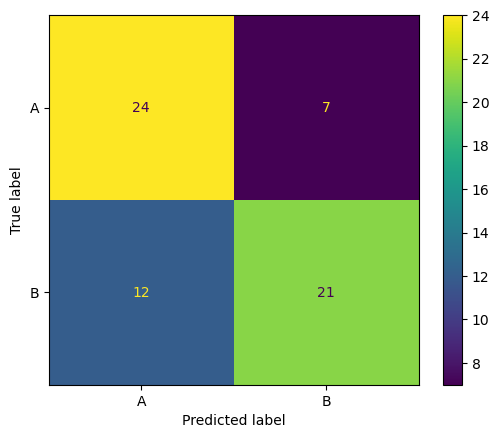


Results for season 2006:
Accuracy predictions: 0.640625
Confusion matrix:


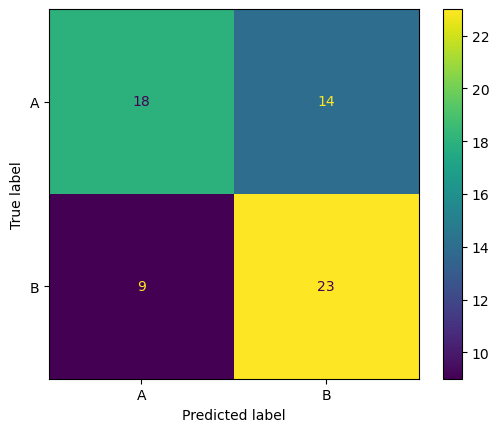


Results for season 2007:
Accuracy predictions: 0.765625
Confusion matrix:


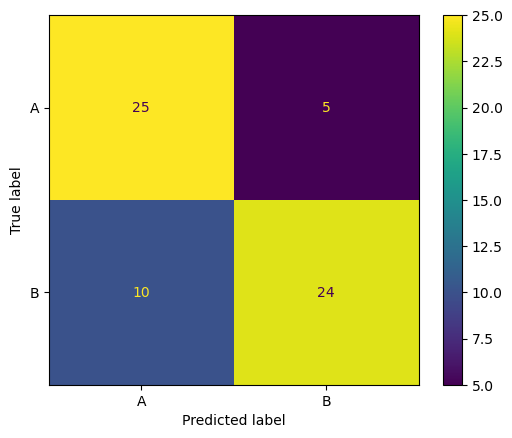


Results for season 2008:
Accuracy predictions: 0.765625
Confusion matrix:


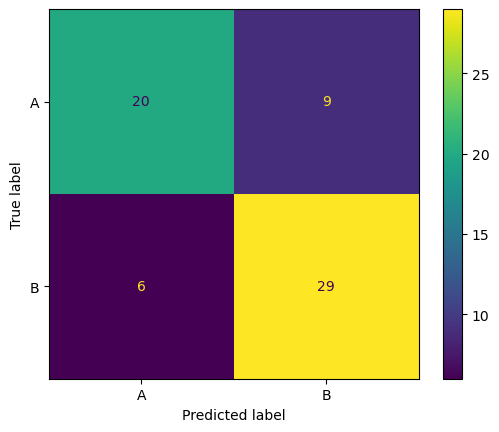


Results for season 2009:
Accuracy predictions: 0.671875
Confusion matrix:


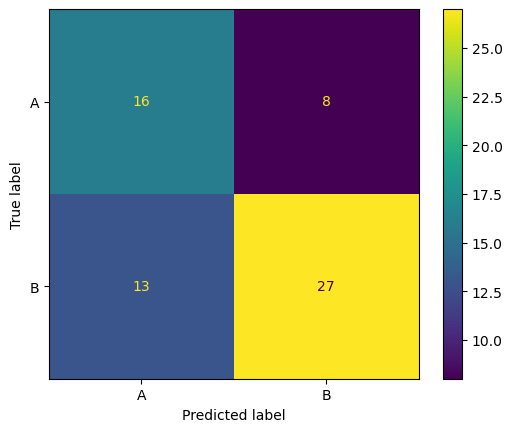


Results for season 2010:
Accuracy predictions: 0.671875
Confusion matrix:


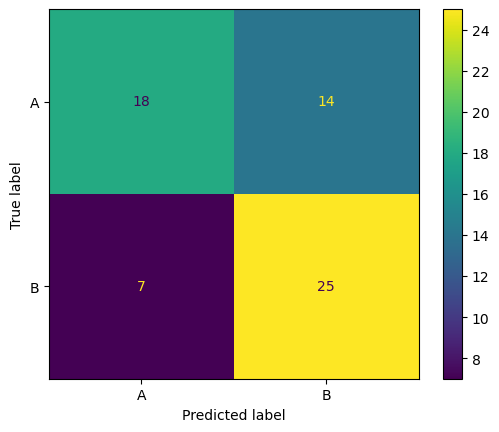


Results for season 2011:
Accuracy predictions: 0.6119402985074627
Confusion matrix:


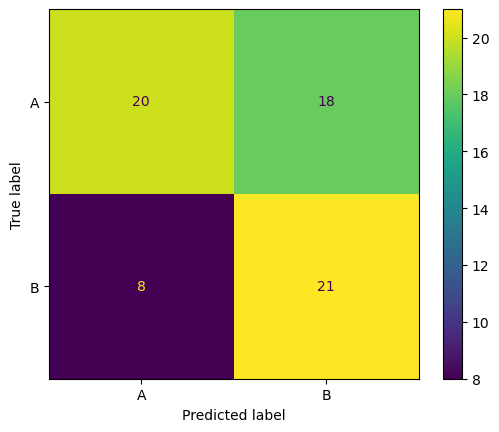


Results for season 2012:
Accuracy predictions: 0.7014925373134329
Confusion matrix:


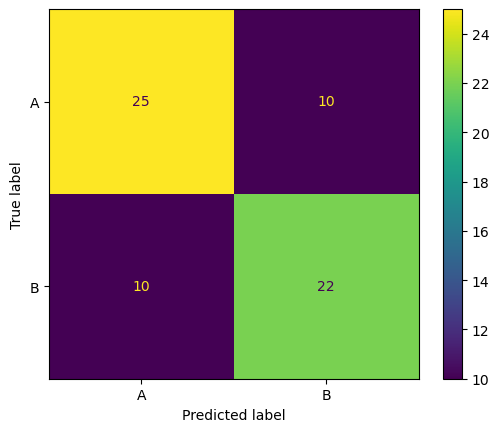


Results for season 2013:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


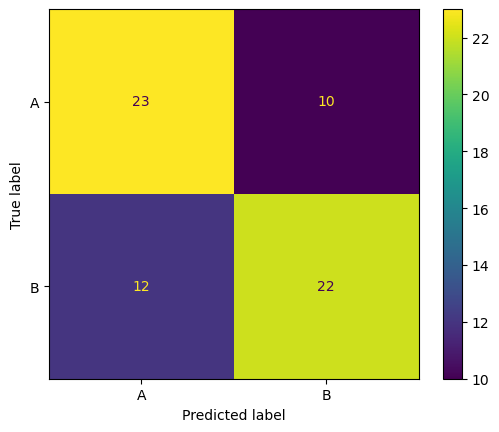


Results for season 2014:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


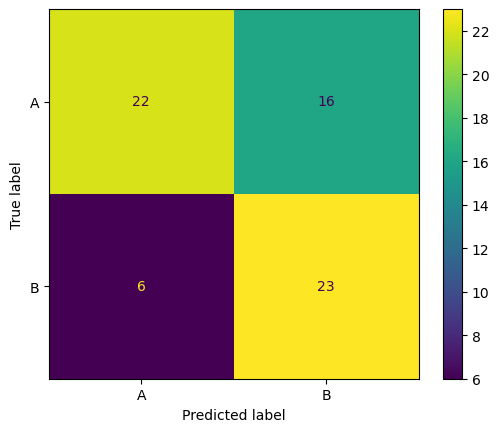


Results for season 2015:
Accuracy predictions: 0.7611940298507462
Confusion matrix:


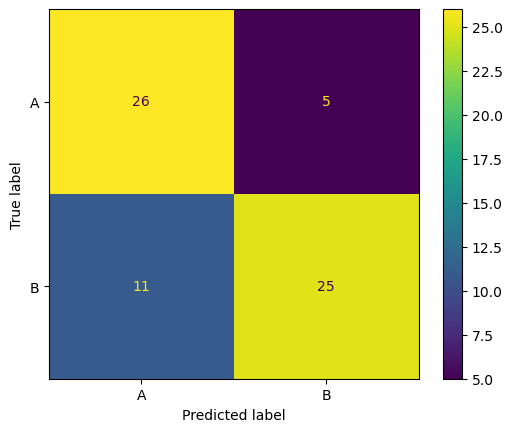


Results for season 2016:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


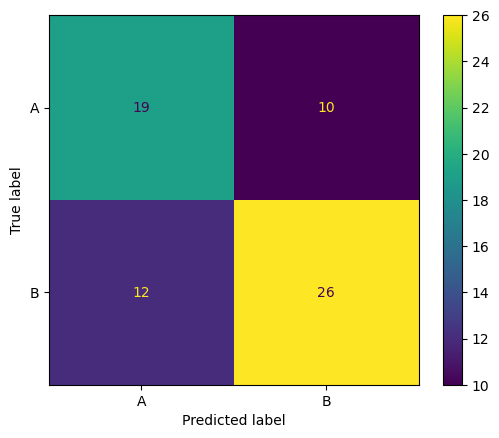


Results for season 2017:
Accuracy predictions: 0.7313432835820896
Confusion matrix:


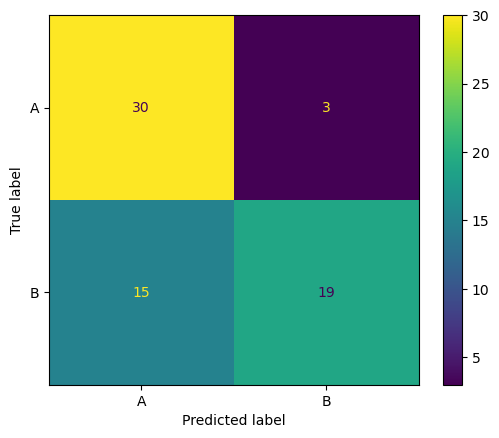


Results for season 2018:
Accuracy predictions: 0.6865671641791045
Confusion matrix:


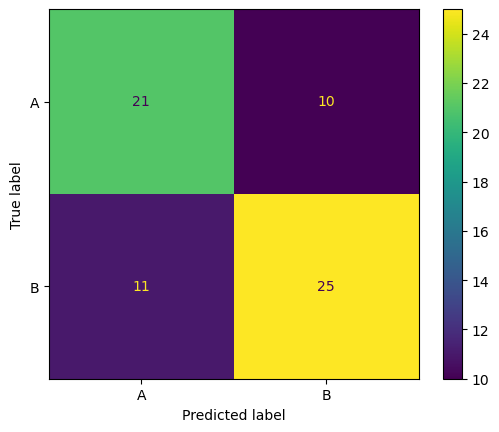


Results for season 2019:
Accuracy predictions: 0.6716417910447762
Confusion matrix:


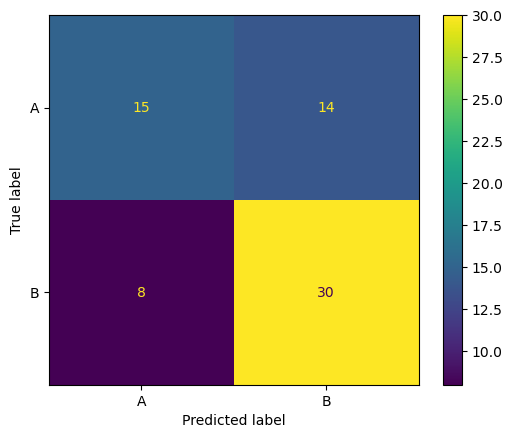


Results for season 2021:
Accuracy predictions: 0.6515151515151515
Confusion matrix:


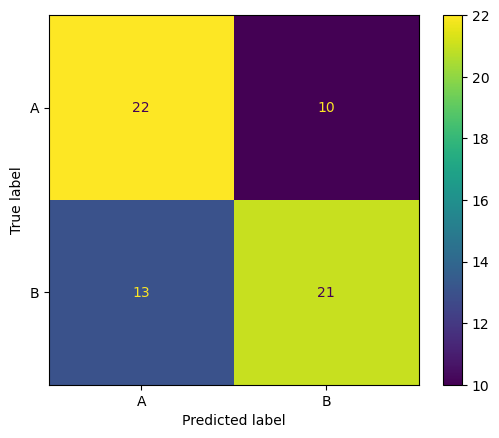


Results for season 2022:
Accuracy predictions: 0.7164179104477612
Confusion matrix:


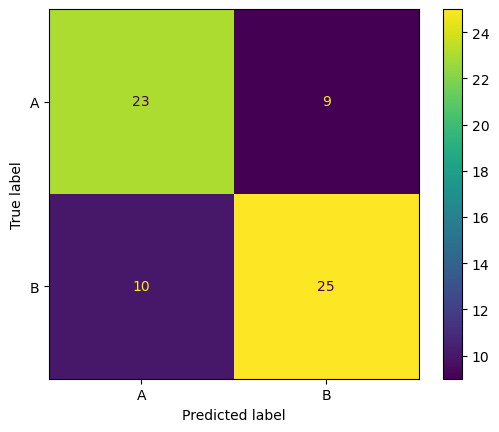



Mean Accuracy: 0.6921051493867562


In [10]:
acc_sum = 0
seasons_count = 0

for season in range(start_data_season + 2, 2024):
    data_train = data_df[(data_df['Season'] < season)].reset_index(drop=True)
    data_test = data_df[(data_df['Season'] == season)].reset_index(drop=True)
    
    if not len(data_test):
        continue
    
    x_train = data_train.drop(['Winner'], axis=1)
    y_train = data_train.loc[:, 'Winner']
    
    x_test = data_test.drop(['Winner'], axis=1)
    y_test = data_test.loc[:, 'Winner']
    
    classifier = RandomForestClassifier(random_state=0)
    classifier.fit(x_train, y_train)
    
    predictions = classifier.predict(x_test)
    
    print(f'\nResults for season {season}:')
    acc = accuracy_score(y_test, predictions)
    print('Accuracy predictions:', acc)
    
    acc_sum += acc
    seasons_count += 1
    
    cm = confusion_matrix(y_test, predictions)
    print('Confusion matrix:')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    cm_disp.plot()
    plt.show()
    
print(f'\n\nMean Accuracy: {acc_sum/seasons_count}')


In [11]:
print(predictions)
print(y_test)

['A' 'B' 'A' 'B' 'A' 'A' 'A' 'B' 'A' 'B' 'B' 'A' 'A' 'B' 'A' 'A' 'B' 'A'
 'B' 'B' 'A' 'A' 'B' 'A' 'B' 'B' 'B' 'B' 'A' 'B' 'A' 'B' 'A' 'B' 'B' 'B'
 'A' 'A' 'B' 'B' 'A' 'A' 'A' 'B' 'A' 'A' 'B' 'B' 'A' 'A' 'B' 'B' 'B' 'B'
 'A' 'B' 'A' 'B' 'B' 'A' 'B' 'B' 'A' 'A' 'B' 'A' 'A']
0     A
1     B
2     A
3     B
4     A
     ..
62    A
63    A
64    A
65    B
66    A
Name: Winner, Length: 67, dtype: object
